# Fine-Tune Multi-Layer Perceptron

## Load libraries

In [16]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [5]:
def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer perceptron,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers-1):

            if i == 0:
                # fitst layer: input -> hidden
                model.add(Dense(hidden_size,
                                input_dim=input_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                                input_dim=hidden_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate, seed=0))
        
        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

## Load data

In [6]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

## Preprocess data

In [7]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [8]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


In [9]:
# extract features
train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
train_4_gram = [n_gram(tokens, 4) for tokens in train_stemmed]
valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]
valid_3_gram = [n_gram(tokens, 3) for tokens in valid_stemmed]
valid_4_gram = [n_gram(tokens, 4) for tokens in valid_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]
test_4_gram = [n_gram(tokens, 4) for tokens in test_stemmed]

In [10]:
# build the feature list
train_feats = list()
for i in range(train_size):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i] + train_4_gram[i])
    
valid_feats = list()
for i in range(valid_size):
    valid_feats.append(
        valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i] + valid_4_gram[i])

test_feats = list()
for i in range(test_size):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i] + test_4_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
                chain.from_iterable(train_feats),
                min_freq=4)

train_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in train_feats])
valid_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in valid_feats])
test_feats_matrix = np.vstack([get_onehot_vector(f, feats_dict) for f in test_feats])

train_label_matrix = tf.keras.utils.to_categorical(train_labels, num_classes=9)
valid_label_matrix = tf.keras.utils.to_categorical(valid_labels, num_classes=9)
test_label_matrix = tf.keras.utils.to_categorical(test_labels, num_classes=9)

Size of features: 4431


C:\Users\cinni\AppData\Local\Temp\ipykernel_14672\3336279750.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vector = np.zeros(len(feats_dict), dtype=np.float)


## Fine-Tune Model  
  
num_layers  
hidden_size  
activation  
dropout_rate  
batch_norm  
layer_norm  
l2_reg  
optimizer  
learning_rate  

In [11]:
# set seed
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# indicator for saving models' weights
count = 0

# initial settings
epoch = 20
batch_size = 100
optimizer = "SGD"
num_layers = 3
hidden_size = 300
activation = "relu"
dropout_rate = 0.3
batch_norm = False
layer_norm = False
l2_reg = 0.005
learning_rate = 0.1

### optimizer

In [13]:
optimizer_list = ['SGD', 'RMSprop', 'Adam']
best_optimizer = ''
best_acc = 0
best_f1 = 0

for optimizer in optimizer_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'optimizer: {optimizer}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_optimizer = optimizer
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'optimizer: {best_optimizer}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 1
optimizer: SGD
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8469
macro_f1: 0.8468
----------------------------------------------------------------------------
count: 2
optimizer: RMSprop
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8444
macro_f1: 0.8435
----------------------------------------------------------------------------
count: 3
optimizer: Adam
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8519
macro_f1: 0.8526
----------------------------------------------------------------------------
Best model:
optimizer: Adam, accuracy: 0.8518518518518519, macro_f1: 0.8526174686856167


In [14]:
optimizer = best_optimizer

### num_layers

In [15]:
num_layers_list = [1, 2, 3, 4, 5]
best_num_layers = 0
best_acc = 0
best_f1 = 0

for num_layers in num_layers_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'num_layers: {num_layers}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_num_layers = num_layers
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'num_layers: {best_num_layers}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 4
num_layers: 1
13/13 [==============================] - 0s 3ms/step
accuracy: 0.8296
macro_f1: 0.8304
----------------------------------------------------------------------------
count: 5
num_layers: 2
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8519
macro_f1: 0.8515
----------------------------------------------------------------------------
count: 6
num_layers: 3
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8543
macro_f1: 0.8548
----------------------------------------------------------------------------
count: 7
num_layers: 4
13/13 [==============================] - 0s 11ms/step
accuracy: 0.8469
macro_f1: 0.8473
----------------------------------------------------------------------------
count: 8
num_layers: 5
13/13 [==============================] - 0s 10ms/step
accuracy: 0.8370
macro_f1: 0.8378
----------------------------------------------------------------------------
Best model:
num_layers: 3, accuracy: 0.854320987654321, macro_f

In [16]:
num_layers = best_num_layers

### hidden_size

In [17]:
hidden_size_list = [100, 200, 300, 400, 500]
best_hidden_size = 0
best_acc = 0
best_f1 = 0

for hidden_size in hidden_size_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'hidden_size: {hidden_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_hidden_size = hidden_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'hidden_size: {best_hidden_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 9
hidden_size: 100
13/13 [==============================] - 0s 7ms/step
accuracy: 0.8543
macro_f1: 0.8555
----------------------------------------------------------------------------
count: 10
hidden_size: 200
13/13 [==============================] - 0s 7ms/step
accuracy: 0.8593
macro_f1: 0.8592
----------------------------------------------------------------------------
count: 11
hidden_size: 300
13/13 [==============================] - 0s 7ms/step
accuracy: 0.8494
macro_f1: 0.8497
----------------------------------------------------------------------------
count: 12
hidden_size: 400
13/13 [==============================] - 0s 10ms/step
accuracy: 0.8469
macro_f1: 0.8473
----------------------------------------------------------------------------
count: 13
hidden_size: 500
13/13 [==============================] - 0s 10ms/step
accuracy: 0.8494
macro_f1: 0.8496
----------------------------------------------------------------------------
Best model:
hidden_size: 200, accuracy: 0.85

In [18]:
hidden_size = best_hidden_size

### dropout_rate

In [19]:
dropout_rate_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
best_dropout_rate = 0
best_acc = 0
best_f1 = 0

for dropout_rate in dropout_rate_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'dropout_rate: {dropout_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_dropout_rate = dropout_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'dropout_rate: {best_dropout_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 14
dropout_rate: 0
13/13 [==============================] - 0s 8ms/step
accuracy: 0.8420
macro_f1: 0.8426
----------------------------------------------------------------------------
count: 15
dropout_rate: 0.1
13/13 [==============================] - 0s 8ms/step
accuracy: 0.8444
macro_f1: 0.8452
----------------------------------------------------------------------------
count: 16
dropout_rate: 0.2
13/13 [==============================] - 0s 6ms/step
accuracy: 0.8543
macro_f1: 0.8546
----------------------------------------------------------------------------
count: 17
dropout_rate: 0.3
13/13 [==============================] - 1s 7ms/step
accuracy: 0.8469
macro_f1: 0.8477
----------------------------------------------------------------------------
count: 18
dropout_rate: 0.4
13/13 [==============================] - 1s 13ms/step
accuracy: 0.8593
macro_f1: 0.8591
----------------------------------------------------------------------------
count: 19
dropout_rate: 0.5
13/13 [======

In [20]:
dropout_rate = best_dropout_rate

### batch_norm

In [21]:
batch_norm_list = [True, False]
best_batch_norm = False
best_acc = 0
best_f1 = 0

for batch_norm in batch_norm_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'batch_norm: {batch_norm}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_batch_norm = batch_norm
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'batch_norm: {best_batch_norm}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 22
batch_norm: True
13/13 [==============================] - 4s 17ms/step
accuracy: 0.8444
macro_f1: 0.8450
----------------------------------------------------------------------------
count: 23
batch_norm: False
13/13 [==============================] - 3s 19ms/step
accuracy: 0.8593
macro_f1: 0.8591
----------------------------------------------------------------------------
Best model:
batch_norm: False, accuracy: 0.8592592592592593, macro_f1: 0.8590514347883086


In [22]:
batch_norm = best_batch_norm

### layer_norm

In [23]:
layer_norm_list = [True, False]
best_layer_norm = False
best_acc = 0
best_f1 = 0

for layer_norm in layer_norm_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'layer_norm: {layer_norm}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_layer_norm = layer_norm
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'layer_norm: {best_layer_norm}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 24
layer_norm: True
13/13 [==============================] - 8s 19ms/step
accuracy: 0.8469
macro_f1: 0.8468
----------------------------------------------------------------------------
count: 25
layer_norm: False
13/13 [==============================] - 1s 13ms/step
accuracy: 0.8543
macro_f1: 0.8546
----------------------------------------------------------------------------
Best model:
layer_norm: False, accuracy: 0.854320987654321, macro_f1: 0.854624655867402


In [24]:
layer_norm = best_layer_norm

### l2_reg

In [25]:
l2_reg_list = [0.001, 0.005, 0.01, 0.1]
best_l2_reg = 0
best_acc = 0
best_f1 = 0

for l2_reg in l2_reg_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'l2_reg: {l2_reg}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_l2_reg = l2_reg
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'l2_reg: {best_l2_reg}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 26
l2_reg: 0.001
13/13 [==============================] - 2s 21ms/step
accuracy: 0.8568
macro_f1: 0.8569
----------------------------------------------------------------------------
count: 27
l2_reg: 0.005
13/13 [==============================] - 1s 12ms/step
accuracy: 0.8617
macro_f1: 0.8617
----------------------------------------------------------------------------
count: 28
l2_reg: 0.01
13/13 [==============================] - 3s 16ms/step
accuracy: 0.8568
macro_f1: 0.8571
----------------------------------------------------------------------------
count: 29
l2_reg: 0.1
13/13 [==============================] - 5s 21ms/step
accuracy: 0.7481
macro_f1: 0.7424
----------------------------------------------------------------------------
Best model:
l2_reg: 0.005, accuracy: 0.8617283950617284, macro_f1: 0.8617415180616969


In [26]:
l2_reg = best_l2_reg

### learning_rate

In [27]:
learning_rate_list = [0.0001, 0.001, 0.01, 0.1]
best_learning_rate = 0
best_acc = 0
best_f1 = 0

for learning_rate in learning_rate_list:

    count += 1

    model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_MLP_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_MLP_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'learning_rate: {learning_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_learning_rate = learning_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'learning_rate: {best_learning_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 30
learning_rate: 0.0001
13/13 [==============================] - 4s 18ms/step
accuracy: 0.8543
macro_f1: 0.8535
----------------------------------------------------------------------------
count: 31
learning_rate: 0.001
13/13 [==============================] - 1s 23ms/step
accuracy: 0.8543
macro_f1: 0.8542
----------------------------------------------------------------------------
count: 32
learning_rate: 0.01
13/13 [==============================] - 3s 17ms/step
accuracy: 0.8593
macro_f1: 0.8595
----------------------------------------------------------------------------
count: 33
learning_rate: 0.1
13/13 [==============================] - 2s 17ms/step
accuracy: 0.8543
macro_f1: 0.8549
----------------------------------------------------------------------------
Best model:
learning_rate: 0.01, accuracy: 0.8592592592592593, macro_f1: 0.8595305056652044


In [28]:
learning_rate = best_learning_rate

## Final Multi-Layer Perceptron Model

In [30]:
epoch = 50

In [31]:
model = build_MLP(input_size=len(feats_dict), 
                      output_size=num_labels,
                      num_layers=num_layers,
                      hidden_size=hidden_size,
                      activation=activation,
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      layer_norm=layer_norm, 
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", f"weights_MLP_final.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(valid_feats_matrix, valid_label_matrix),
                    epochs=epoch, batch_size=batch_size, verbose=1,
                    callbacks=[checkpointer])

model = keras.models.load_model(os.path.join("models", f"weights_MLP_final.hdf5"))


# evaluation
# generate prediction and format
y_pred = model.predict(valid_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred, average='macro')
print(f'accuracy: {acc:.4f}')
print(f'macro_f1: {f1:.4f}')

Epoch 1/50
37/37 [==============================] - 107s 1s/step - loss: 4.6720 - accuracy: 0.1748 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.7637 - val_accuracy: 0.6815 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 5s 142ms/step - loss: 3.3253 - accuracy: 0.3811 - precision: 0.9306 - recall: 0.0184 - val_loss: 2.7671 - val_accuracy: 0.7457 - val_precision: 1.0000 - val_recall: 0.0519
Epoch 3/50
37/37 [==============================] - 4s 104ms/step - loss: 2.4537 - accuracy: 0.6019 - precision: 0.9171 - recall: 0.1852 - val_loss: 1.9966 - val_accuracy: 0.7951 - val_precision: 0.9742 - val_recall: 0.3728
Epoch 4/50
37/37 [==============================] - 5s 132ms/step - loss: 1.8779 - accuracy: 0.7396 - precision: 0.9110 - recall: 0.4549 - val_loss: 1.6621 - val_accuracy: 0.8222 - val_precision: 0.9556 - val_recall: 0.5852
Epoch 5/50
37/37 [==============================] - 5s 133ms/step - loss: 1.5528 - accura

## Final Model Test Prediction

In [12]:
model = keras.models.load_model(os.path.join("models", f"weights_MLP_final.hdf5"))

In [17]:
# generate prediction and format
y_pred = model.predict(test_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='macro')
print(f'test accuracy: {acc:.4f}')
print(f'test macro_f1: {f1:.4f}')
print(classification_report(test_labels, y_pred,target_names=labels))

15/15 [==============================] - 0s 3ms/step
test accuracy: 0.8800
test macro_f1: 0.8803
              precision    recall  f1-score   support

          CC       0.92      0.94      0.93        50
          NC       0.94      0.88      0.91        50
          PW       0.88      0.86      0.87        50
          HC       0.78      0.80      0.79        50
          PL       0.82      0.90      0.86        50
          CR       0.84      0.82      0.83        50
          CG       0.94      0.92      0.93        50
          BE       0.90      0.90      0.90        50
           N       0.92      0.90      0.91        50

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



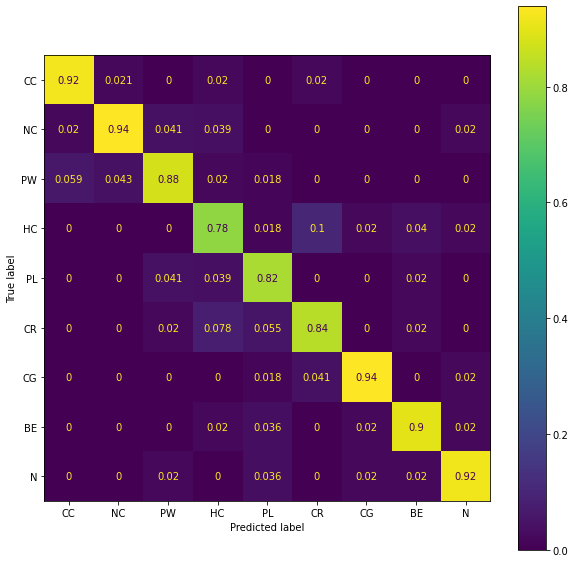

In [18]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)